# I. Introduction

The highest-granularity traffic data published on New York City traffic is the data packaged as a part of the [New York State Traffic Data Viewer](https://www.dot.ny.gov/tdv), which includes traffic volumes by street segment for most major roadways in New York City. There are an abundance of local streets not included in this (circa <=2014) data, however.

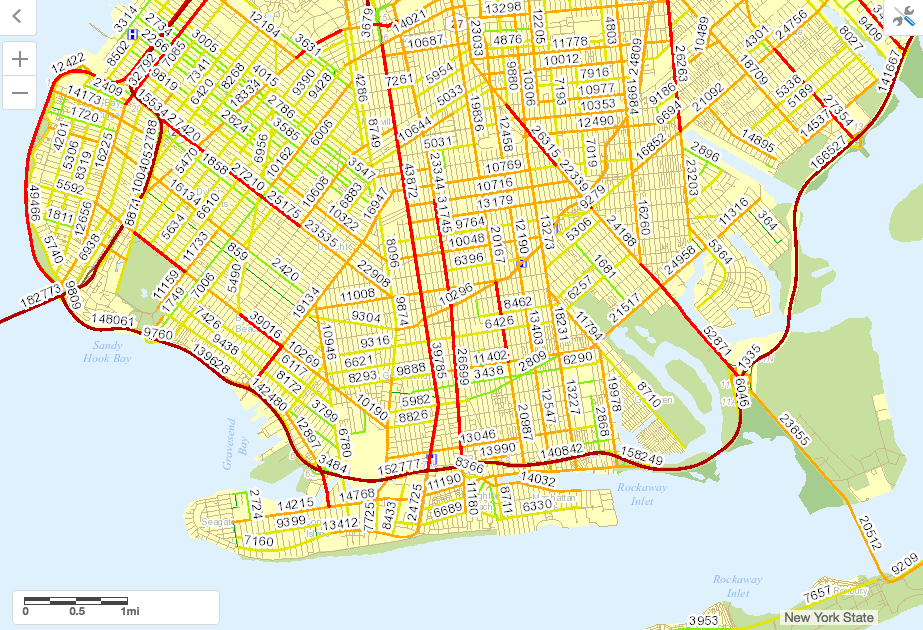

In [7]:
from IPython.display import Image
Image("../figures/NYS Traffic Data Viewer Screenshot.png")

The city-published [motor vehicle collision incident dataset](https://data.cityofnewyork.us/Public-Safety/NYPD-Motor-Vehicle-Collisions/h9gi-nx95) includes geocoded entries for all motor vehicle collisions reported to the city’s police department. These entries, which mostly correspond with street intersections throughout the city, provide a high-granularity view of motor vehicle collision incidents going back several years.

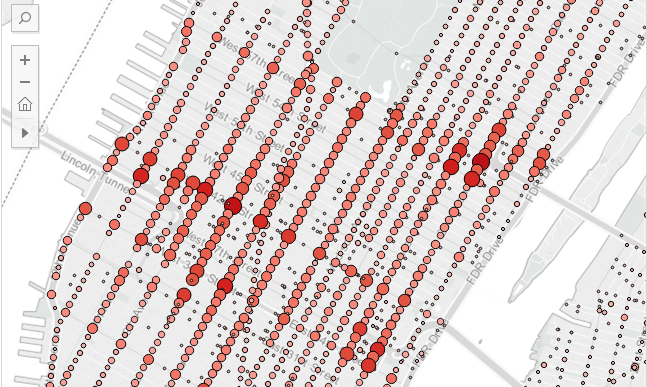

In [8]:
Image("../figures/Midtown Manhattan Accident Map Zoomed.png")

[Prior work with the traffic collision data](http://www.residentmar.io/2016/03/23/worst-places-to-drive.html) seems to evidence that collision volumes are primarily a function not of local street topography, but of street traffic volume. In other words, the "natural accident rate" of a street intersection or segment (in terms of accidents per unit volume of traffic) is relatively stable. This makes sense: above random variation, easily generalizable features of especially safe streets would have been carried out to streets elsewhere, and causal features of especially collision-prone streets mitigated, under the oversight of the city’s traffic management teams.

We can use the state-collected average daily traffic data as ground truths for a model, linear or otherwise, expressing hypothesized traffic volume as a function of the accident collision rate on the given street segment. In other words, we will take the motor vehicle collision incident rate for major local streets from the motor vehicle collision dataset, match that with average daily traffic volumes on those streets given by the state data, and build a model for the latter as a function of the former; then extend that model to local street collision data also in the collisions dataset. The end product will be a map of street-wise traffic for all streets in New York City – an improvement on the state’s view, which includes only major streets (albeit quite many of them).

Since the motor vehicle collision dataset is point-based, the point (aggregate points, really, since each intersection likely has a number of collisions associated with it in the dataset) will need to be associated with streets in the New York State data’s shapefile grid.

Later on, a further dataset of street-line data for the city of New York will be needed, as street intersection points in the geocoded motor vehicle collision dataset need to be matched with and embedded into local street-lines for New York City at large, not just the ones that happen to be present in the state data. This is the [New York City LION dataset](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-lion.page) (whose purpose, origin, and structure described in some depth [here](https://spatialityblog.com/2015/10/07/hidden-beauty-in-the-nyc-lion-file/)).

Two final notes. Traffic collision geotagging is missing for highways and arterial roads, as well as bridges; I'm not sure where these accidents get reported and geolocated to instead. For these entities, though, we have the state data to rely on.

The second note is that streets occassionally appear to run on top of other streets, as for instance happens when a major arterial road passes over a local. This can cause a convolution of geographical data, since, unfortunately, there is no `z` component to a coordinate. I will have to think how to address this later on.

# II. Environment

Running the sequence of notebooks which make up this project requires setting up the environment. Since this project uses quite a few packages, this may be moderately difficult, especially on Windows. You can see the list of things you need to install by checking the `environment.yml` file in this project's root folder, and you can try to install them yourself by running the following command:

    conda env create -f environment.yml

# III. Localizing Data

## Average Daily Traffic Dataset

This first notebook concerns itself with localizing the state's [traffic viewer data](https://www.dot.ny.gov/tdv). From here on I will refer to this as the average daily traffic dataset.

In [12]:
import requests

# Fetch the raw zipfile.
r = requests.get("https://www.dot.ny.gov/divisions/engineering/applications/traffic-data-viewer/traffic-data-viewer-repository/TDV_Shapefile_AADT_2014.zip",
                 verify=False)
# Raise an error if an error occurred (perhaps the URL moved?)
r.raise_for_status()

/Users/Honors/anaconda/envs/nyc-restaurant-trends/lib/python3.5/site-packages/requests/packages/urllib3/connectionpool.py:838: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/security.html
  InsecureRequestWarning)


Note the need to pass `verify=False` to the `requests.get()` method. This is because the state website [seems to fail the SSL handshake](http://stackoverflow.com/questions/34503206/ssl-certificate-verify-failed-python):

```python
SSLError: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:645)
```

Omitting SSL certification entirely in this manner is not recommended in production, but since we're writing a script chunking data from a state government website, we don't care.

The compressed data is somewhat more than 20 MB:

In [23]:
int(r.headers['Content-Length']) / 1000000

23.142022

The contents of the `ZIP` we just downloaded is a `sph` shapefile and its supportive subfiles:

In [26]:
import io
import zipfile

zips = zipfile.ZipFile(io.BytesIO(r.content), 'r')

In [28]:
zips.filelist

[<ZipInfo filename='AADT_2014.shp' compress_type=deflate external_attr=0x20 file_size=28804852 compress_size=17521046>,
 <ZipInfo filename='AADT_2014.shp.xml' compress_type=deflate external_attr=0x20 file_size=26617 compress_size=4778>,
 <ZipInfo filename='AADT_2014.shx' compress_type=deflate external_attr=0x20 file_size=439740 compress_size=217280>,
 <ZipInfo filename='AADT_2014.dbf' compress_type=deflate external_attr=0x20 file_size=189760321 compress_size=5226611>,
 <ZipInfo filename='AADT_2014.prj' compress_type=deflate external_attr=0x20 file_size=424 compress_size=268>,
 <ZipInfo filename='AADT_2014.sbn' compress_type=deflate external_attr=0x20 file_size=361692 compress_size=163559>,
 <ZipInfo filename='AADT_2014.sbx' compress_type=deflate external_attr=0x20 file_size=16820 compress_size=7736>]

Let's extract this data locally.

In [30]:
!mkdir "../data"
!mkdir "../data/aadt"

mkdir: ../data: File exists


In [31]:
zips.extractall(path="../data/aadt")

In [32]:
%ls "../data/aadt"

AADT_2014.dbf      AADT_2014.sbn      AADT_2014.shp      AADT_2014.shx
AADT_2014.prj      AADT_2014.sbx      AADT_2014.shp.xml


The decompressed files are almost 220 MB, which is very managable:

In [51]:
import os
sum(os.path.getsize('../data/aadt/' + f) 
    for f in os.listdir('../data/aadt') 
    if os.path.isfile('../data/aadt/' + f)) / 1000000

219.410466

## Motor Vehicle Collision Data

This is even more straightforward, since it's provided in `CSV` format.

In [36]:
!mkdir "../data/mvc"
import pandas as pd
pd.read_csv("https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.csv?accessType=DOWNLOAD")\
    .to_csv("../data/mvc/mvc.csv", encoding='utf-8')

mkdir: ../data/mvc: File exists


In [37]:
%ls "../data/mvc"

mvc.csv


This comes out to be 180 MB (so a similar size):

In [53]:
sum(os.path.getsize('../data/mvc/' + f) 
    for f in os.listdir('../data/mvc') 
    if os.path.isfile('../data/mvc/' + f)) / 1000000

182.262058

## New York City LION

NYC City Planning makes this data available in Esri's proprietary geodatabase format (more info on the format [here](http://blogs.library.duke.edu/data/2015/09/14/shapefiles-vs-geodatabases/)). This is a bit difficult to read, and apparently Esri was really slow on opening the format up to the public (they exist to make you use their expensive proprietary GIS products, after all).

In modern times `ogr2ogr` can read it now, apparently (see [here](http://stackoverflow.com/questions/37705217/how-to-read-a-table-from-an-esri-file-geodatabase-gdb-using-r) and [here](http://gis.stackexchange.com/questions/4076/open-source-tool-capable-of-reading-esri-file-geodatabase-gdb)), but we don't need to bother. We can use a slightly older but no less for the wear version of this dataset, circa October 2015, which was [cross-released by the CUNY Graduate Center](https://spatialityblog.com/2015/10/07/hidden-beauty-in-the-nyc-lion-file/) in the usual old-school `shapefile` format.

In [54]:
r = requests.get("https://wfs.gc.cuny.edu/SRomalewski/NYCLION/nyclion_15c.zip")

The compressed version is about 30 MB.

In [56]:
int(r.headers['Content-Length']) / 1000000

30.981703

In [57]:
zips = zipfile.ZipFile(io.BytesIO(r.content), 'r')

In [58]:
zips.filelist

[<ZipInfo filename='nyclion_15c.dbf' compress_type=deflate external_attr=0x20 file_size=109595892 compress_size=20451337>,
 <ZipInfo filename='nyclion_15c.prj' compress_type=deflate external_attr=0x20 file_size=562 compress_size=329>,
 <ZipInfo filename='nyclion_15c.shp' compress_type=deflate external_attr=0x20 file_size=22192652 compress_size=9906273>,
 <ZipInfo filename='nyclion_15c.shp.xml' compress_type=deflate external_attr=0x20 file_size=72029 compress_size=13972>,
 <ZipInfo filename='nyclion_15c.shx' compress_type=deflate external_attr=0x20 file_size=1719196 compress_size=609232>]

In [59]:
!mkdir "../data/lion"
zips.extractall(path="../data/lion")

Strangely this one is a little smaller:

In [60]:
sum(os.path.getsize('../data/lion/' + f) 
    for f in os.listdir('../data/lion') 
    if os.path.isfile('../data/lion/' + f)) / 1000000

133.580331

In [61]:
%ls "../data/lion"

nyclion_15c.dbf      nyclion_15c.shp      nyclion_15c.shx
nyclion_15c.prj      nyclion_15c.shp.xml
